In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.feature_map import ChebRx
from squlearn.expectation_operator import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss, VarianceLoss
from squlearn.optimizers import SLSQP

Define parameterized quantum circuit $Q(x,\theta)$

In [2]:
executor = Executor("statevector_simulator")

Definition of the cost operator:
$\hat{H} = J \sum\limits_{i < j} Z_i Z_j + h\sum\limits_i Z_i + c$

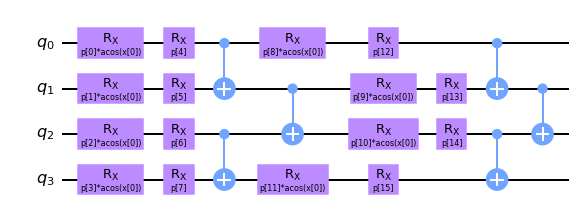

In [3]:
nqubits = 4

number_of_layers = 2
pqc = ChebRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw()

In [4]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SummedOp([
  1.0*p[0] * IIII,
  1.0*p[1] * IIIZ,
  1.0*p[1] * IIZI,
  1.0*p[1] * IZII,
  1.0*p[1] * ZIII,
  1.0*p[2] * IIZZ,
  1.0*p[2] * IZIZ,
  1.0*p[2] * IZZI,
  1.0*p[2] * ZIIZ,
  1.0*p[2] * ZIZI,
  1.0*p[2] * ZZII
])


Example function: $log(x)$

In [5]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(
    pqc,
    ising_op,
    executor,
    SquaredLoss(),
    SLSQP(),
    param_ini,
    param_op_ini,
    variance=0.0005,
)

Optimization of the regression

In [6]:
reg.fit(x_space, ref_values)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
pre-processing 0.003000497817993164
Total number of circuits: 8
sampler run time 0.04601407051086426
post processing 0.003999471664428711
Current value: 15.066309647593316
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
pre-processing 0.16496610641479492
Total number of circuits: 256
sampler run time 0.5330045223236084
post processing 0.10499405860900879
c
pre-processing 0.0020012855529785156
Total number of circuits: 8
sampler run time 0.04000568389892578
post processing 0.009994029998779297
Grad length: 23.533663695454393
grad [ -0.05707629  -1.19647308  -2.50681693  -0.15744595  -0.26520563
  -0.92

In [8]:
print("Result Param:", reg._param)
print("Result ParamOp:", reg._param_op)

Result Param: [ 3.40667639  0.63355211  4.38972674  1.25754197 -2.34977374 -0.04090919
 -4.21779589 -0.19173701  0.22921055  0.7861282   3.04314945  0.59024225
 -0.53440131 -1.55317834 -2.07561038 -0.28741558]
Result ParamOp: [-1.57560196  0.88284706 -0.27194698]


pre-processing 0.040998220443725586
Total number of circuits: 140
sampler run time 0.3710010051727295
post processing 0.028000593185424805


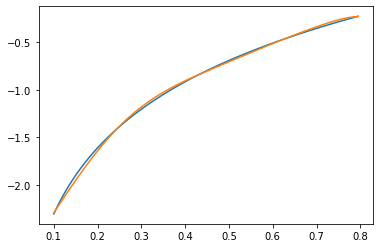

In [9]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

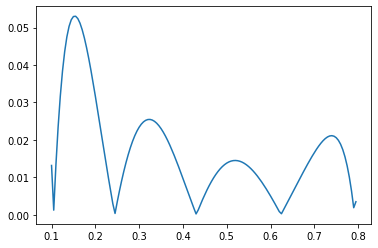

In [10]:
plt.plot(x, np.abs(y - np.log(x)))

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:133: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


pre-processing 0.0389862060546875
Total number of circuits: 140
sampler run time 0.4170827865600586
post processing 0.026002168655395508


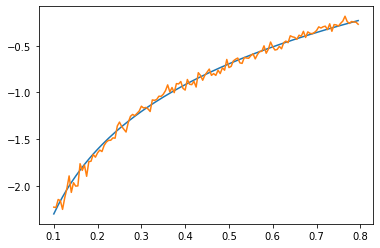

In [11]:
qasm = Executor("qasm_simulator")
qnn_qasm = QNNRegressor(
    pqc, ising_op, qasm, [SquaredLoss, VarianceLoss], SLSQP(), reg._param, reg._param_op
)
y = qnn_qasm.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

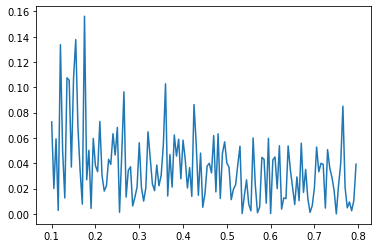

In [12]:
plt.plot(x, np.abs(y - np.log(x)))